## Librerias

In [1]:
#ARREGLAR GRÁFICAS, AÑADIR POBLACIÓN

In [ ]:
#INDEPENDIENTE 

In [1]:
rm(list=ls())
library(foreign)
library(Synth)
library(xtable)
library(openxlsx)

##
## Synth Package: Implements Synthetic Control Methods.

## See https://web.stanford.edu/~jhain/synthpage.html for additional information.


Warning message:
"package 'openxlsx' was built under R version 3.6.3"

In [3]:
body(synth)

{
    if (is.null(data.prep.obj) == FALSE) {
        cat("\nX1, X0, Z1, Z0 all come directly from dataprep object.\n\n")
        X1 <- data.prep.obj$X1
        Z1 <- data.prep.obj$Z1
        X0 <- data.prep.obj$X0
        Z0 <- data.prep.obj$Z0
    }
    else {
        cat("X1,X0,Z1,Z0 were individually input (not dataprep object.)\n\n")
    }
    store <- list(X1 = X1, X0 = X0, Z1 = Z1, Z0 = Z0)
    for (i in 1:4) {
        if (is.null(store[[i]])) {
            stop(paste("\n", names(store)[i], "is missing \n"))
        }
        if (sum(is.na(store[[i]])) > 0) {
            stop(paste("\n NAs in", names(store)[i], "\n"))
        }
        if (is.matrix(store[[i]]) == FALSE) {
            stop(paste("\n", names(store)[i], "is not a matrix object\n"))
        }
    }
    if (ncol(X1) != 1) {
        stop("\n Please specify only one treated unit: X1 has to have ncol= 1")
    }
    if (ncol(Z1) != 1) {
        stop("\n Please specify only one treated unit: Z1 has to have ncol= 1")
    }

In [2]:
.libPaths()

[1] "C:/Users/War/anaconda3/envs/R/Lib/R/library"

In [13]:
# POBLACIÓN
# CAMBIAR VENTANA HACIA DELANTE (22)

## Load data

In [14]:
# Load Data 
df <- read.dta("dbec_vf.dta")

In [39]:
df["POP"] <- log(df["POP"], base = 10)

In [63]:
year_t0 = 1995 #AÑO AL INICIO
year_t1 = 2010 #AÑO ANTES DEL TRATAMIENTO
year_t2 = 2016 #AÑO FINAL

d<-df[df$DATE<=year_t2,]
d<-d[d$DATE>=year_t0,]


pais = "PER"
# pais = "COL"
# pais = "HND"

code_treated = d[d$ISO3==pais,]$WEO_CODE[1]


# muestra <- "LAC"
muestra <- "CLU"
# muestra <- "CLU&LAC"

if (muestra == "LAC") {
    d <- d[d$LAC1 == 1, ]
} else if (muestra == "CLU") {
    d <- d[(d$CLUSTER>=4 | d$WEO==293) & (d$LAC1!=1 | d$WEO==293),]
} else if (muestra == "CLU&LAC") {
    d <- d[(d$CLUSTER>=3 | d$WEO==293) | (d$LAC1==1 | d$WEO==293),]
}

# Crear una carpeta
dir.create("RESULTADOS")
directorio = paste0("RESULTADOS/", muestra, pais, year_t1)
dir.create(directorio)

# d <- d[d$CLUSTER>=4 | d$WEO==293,]
# d <- d[d$CLUSTER>=2 | d$WEO==293,]
# d <- d[d$CLUSTER>=4 | d$LAC2==1,]
# d <- d[d$GROUP=="EMDEs" | d$WEO==293,]

Warning message in dir.create("RESULTADOS"):
"'RESULTADOS' already exists"

Warning message in dir.create(directorio):
"'RESULTADOS\CLUPER2010' already exists"

## Run synthetic control

In [64]:
#################################################################################
# PARAMETERS
#################################################################################

predictors_dp       = c("DEBT_GDP","EXP_GDP", "INTRES_GDP")
dependent_dp        = "DEBT_GDP"
id_variable         = which(names(d) == "WEO_CODE")
time_variable       = which(names(d) == "DATE")

special_predictors  = list(list("REV_GDP", year_t0:year_t1, c("mean")),
                           list("TRADE_OPEN", year_t0:year_t1, c("mean")),
                            list("NET_FDI_GDP", year_t0:year_t1, c("mean")),
                            list("LUR", year_t0:year_t1, c("mean")),
                            list("CAP_RETURN", year_t0:year_t1, c("mean")),
                            list("POP", year_t0:year_t1, c("mean")),
                            list("INFLATION", year_t0:year_t1, c("mean"))
                           )

treated             = code_treated 
controls            = setdiff(unique(d$WEO_CODE), treated) #EXLUYENDO AL TRATADO
time_predictors     = year_t0:year_t1
time_ssr            = year_t0:year_t1
names               = which(names(d) == "ISO3")
time_plot           = year_t0:year_t2

#################################################################################
# DATA PREPARATION
#################################################################################


dataprep.out <-
  dataprep(
           foo = d,
           predictors    = predictors_dp,
           dependent     = dependent_dp,
           unit.variable = id_variable,
           time.variable = time_variable,
           special.predictors = special_predictors,
           treatment.identifier = treated,
           controls.identifier = controls,
           time.predictors.prior = time_predictors,
           time.optimize.ssr = time_ssr,
           unit.names.variable = names,
           time.plot = time_plot
         )

#################################################################################
# FIT
#################################################################################
synth.out <- synth(
        data.prep.obj=dataprep.out,
        Margin.ipop=.005,Sigf.ipop=7,Bound.ipop=6
        )

synth.tables <- synth.tab(
                          dataprep.res = dataprep.out,
                          synth.res = synth.out
                          )


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.0003890099 

solution.v:
 0.8715384 0.00743962 0.0004425924 0.0008619269 0.009250292 0.03688044 4.171e-07 0.0001282574 0.07006064 0.003397447 

solution.w:
 3.928e-06 9.039e-07 6.269e-07 0.4012589 0.04873233 5.651e-07 0.04859046 7.477e-07 1.3728e-06 9.159e-07 7.331e-07 3.691e-07 3.39729e-05 8.975e-07 1.5946e-06 3e-10 5.5344e-06 7.328e-07 0.2218124 0.2795531 



## Results

In [65]:
tabla_estimaciones <- createWorkbook()

addWorksheet(tabla_estimaciones, "variables")
pesos <- do.call(rbind.data.frame, synth.tables[2])
descriptivas = do.call(rbind.data.frame, synth.tables[1])
descriptivas <- cbind(row.names(descriptivas), descriptivas)
descriptivas <- cbind(descriptivas, pesos)
writeData(tabla_estimaciones, "variables", descriptivas)


addWorksheet(tabla_estimaciones, "countries")
paises = do.call(rbind.data.frame, synth.tables[3])
writeData(tabla_estimaciones, "countries", paises)


synthY0 <- (dataprep.out$Y0 %*% synth.out$solution.w)
obsLAC  <- aggregate(d["DEBT_GDP"], by=list(d$DATE), mean, na.rm=TRUE)[, 2]
Y1      <- dataprep.out$Y1plot
gap <- dataprep.out$Y1-(dataprep.out$Y0%*%synth.out$solution.w)

fila <- rep(0, length(seq(year_t0, year_t2))); fila[seq(year_t0, year_t2) == year_t1] <- 1

efecto <- data.frame(seq(year_t0, year_t2), ObsLAC = obsLAC, Y1 = Y1, SynthY0 = synthY0, Gap = gap, Fila = fila)
colnames(efecto) <- c("Año", "Average Sample", pais, paste0(pais, "_synth"), "Effect", "Treatment Year")
addWorksheet(tabla_estimaciones, "effects")
writeData(tabla_estimaciones, "effects", efecto)


saveWorkbook(tabla_estimaciones, paste0(directorio, "/Tablas.xlsx"), overwrite = TRUE)


### Resultados gráficos

In [66]:
#################################################################################
# PERU VS SAMPLE
#################################################################################

options(repr.plot.width = 4, repr.plot.height = 4)
cexl = 0.9
par(cex = cexl, cex.axis = cexl, cex.lab = cexl, cex.main = cexl, cex.sub = cexl)

png(paste0(directorio, paste0("/1_", pais, "_vs_sample.png")), width = 600, height = 600)

# Crear el gráfico
plot(year_t0:year_t2, dataprep.out$Y1plot, type="l", ylim=c(0.1,0.9), col="black", lty="solid",
      ylab="Debt/GDP",  xlab="Year", xaxs="i", yaxs="i", lwd=2)

lines(year_t0:year_t2, obsLAC , 
      col="black", lty="dashed", lwd=2)
    
abline(v=year_t1, lty="dotted")

legend("bottomleft", legend = c(pais, "sample"),  lty = c("solid", "dashed"), 
      col = c("black", "black"), cex = 0.8, bg = "white")

dev.off()

#################################################################################
# PERU VS SYTN PERÚ
#################################################################################
options(repr.plot.width = 4, repr.plot.height = 4)
cexl = 0.9
par(cex = cexl, cex.axis = cexl, cex.lab = cexl, cex.main = cexl, cex.sub = cexl)

png(paste0(directorio, paste0("/2_", pais, "_vs_synth.png")), width = 600, height = 600)

# Crear el gráfico
plot(year_t0:year_t2, Y1, type="l", ylim=c(0.1,0.9), col="black", lty="solid",
      ylab="Debt/GDP",  xlab="Year", xaxs="i", yaxs="i", lwd=2)

lines(year_t0:year_t2,  synthY0, 
      col="black", lty="dashed", lwd=2)
    
abline(v=year_t1, lty="dotted")

legend("bottomleft", legend = c(pais, "_synth"),  lty = c("solid", "dashed"), 
      col = c("black", "black"), cex = 0.8, bg = "white")

dev.off()


#################################################################################
# EFECTO
#################################################################################
options(repr.plot.width = 4, repr.plot.height = 4)
cexl = 0.9
par(cex = cexl, cex.axis = cexl, cex.lab = cexl, cex.main = cexl, cex.sub = cexl)

png(paste0(directorio, paste0("/3_", pais, "_effect.png")), width = 600, height = 600)

plot(year_t0:year_t2,gap,
type="l",ylim=c(-0.5,0.5),col="black",lty="solid",
ylab ="DEBT_DGP",
     xlab ="Year",
     xaxs = "i", yaxs = "i",
     lwd=2)
     
abline(h=0,lty="dotted")
abline(v=2010,lty="dotted")

dev.off()

png 
  2

png 
  2

png 
  2

## Inference

Leave-one-out to construct p-values

In [76]:
# Asumiendo que d es tu dataframe y ya está cargado

# Definir los años
year_t0 = 2000 # Año al inicio
year_t1 = 2010 # Año antes del tratamiento
year_t2 = 2015 # Año final

# Lista de tratados
lista_tratados = unique(d$WEO_CODE)

# Preparar un dataframe para guardar los resultados
resultados = data.frame()

resultados_lista = list()

# Bucle para cada país o código en la lista de tratados
for (i in lista_tratados) {
    # Definir variables para dataprep
    # predictors_dp = c("DEBT_GDP","EXP_GDP")
    # dependent_dp = "DEBT_GDP"
    # id_variable = which(names(d) == "WEO_CODE")
    # time_variable = which(names(d) == "DATE")
    # special_predictors = list(list("REV_GDP", year_t0:year_t1, c("mean")))
    # treated = i
    # controls = setdiff(unique(d$WEO_CODE), treated)
    # time_predictors = year_t0:year_t1
    # time_ssr = year_t0:year_t1
    # names_variable = which(names(d) == "ISO3")
    # time_plot = year_t0:year_t2


    predictors_dp       = c("DEBT_GDP","EXP_GDP")
    dependent_dp        = "DEBT_GDP"
    id_variable         = which(names(d) == "WEO_CODE")
    time_variable       = which(names(d) == "DATE")

    special_predictors  = list(list("REV_GDP", year_t0:year_t1, c("mean")),
                            #    list("WGI_CONTR_CORR", year_t0:year_t1, c("mean")),
                            #    list("WGI_GOV_EFFECT", year_t0:year_t1, c("mean")),
                            #    list("WGI_POL_STAB", year_t0:year_t1, c("mean")),
                            list("WGI_REG_QUAL", year_t0:year_t1, c("mean")),
                            list("TRADE_OPEN", year_t0:year_t1, c("mean")),
                            #     list("CONSUMPTION_PC", year_t0:year_t1, c("mean")),
                                list("NET_FDI_GDP", year_t0:year_t1, c("mean")),
                            #  list("BROAD_MONEY_GDP", year_t0:year_t1, c("mean")),
                                list("LUR", year_t0:year_t1, c("mean")),
                                list("CAP_RETURN", year_t0:year_t1, c("mean")),
                            #  list("INT_RESERVES_CAP", year_t0:year_t1, c("mean")),
                                list("INFLATION", year_t0:year_t1, c("mean")),
                                # list("BANK_CRISIS", year_t0:year_t1, c("mean")),
                                list("COMDEP", year_t0:year_t1, c("mean"))) #OTROS PREDICTORES (EN LA MEDIA)


    # special_predictors  = list(list("REV_GDP", year_t0:year_t1, c("mean"))) #OTROS PREDICTORES (EN LA MEDIA)
    treated             = i
    controls            = setdiff(unique(d$WEO_CODE), treated) #EXLUYENDO AL TRATADO
    time_predictors     = year_t0:year_t1
    time_ssr            = year_t0:year_t1
    names               = which(names(d) == "ISO3")
    time_plot           = year_t0:year_t2



    # Ejecutar dataprep
    dataprep.out <- dataprep(
        foo = d,
        predictors = predictors_dp,
        dependent = dependent_dp,
        unit.variable = id_variable,
        time.variable = time_variable,
        special.predictors = special_predictors,
        treatment.identifier = treated,
        controls.identifier = controls,
        time.predictors.prior = time_predictors,
        time.optimize.ssr = time_ssr,
        unit.names.variable = names_variable,
        time.plot = time_plot
    )

    # Ejecutar synth
    synth.out <- synth(
        data.prep.obj = dataprep.out,
        Margin.ipop = .005,
        Sigf.ipop = 7,
        Bound.ipop = 6
    )

    gap <- dataprep.out$Y1-(dataprep.out$Y0%*%synth.out$solution.w)

    # Guardar los resultados
    # Crear un dataframe temporal

    nombre = as.character(i)

    temp_df <- data.frame(nombre = gap)
    
    resultados_lista[[nombre]] <- temp_df

}

# Ver los resultados
resultados <- do.call(cbind, resultados_lista)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.0375686 

solution.v:
 0.1671745 0.1696513 0.001938978 0.000122222 1.0689e-06 0.3135096 0.3106206 0.01311903 0.02380727 5.54684e-05 

solution.w:
 7.7417e-06 2.7e-09 3e-10 1.12e-08 3e-10 1.5e-08 1.41e-08 6.2473e-06 5.4e-09 8.9e-09 0.6665388 0.3332442 3.9e-09 2.05e-08 1.72e-08 0.000202711 2.032e-07 3e-10 2e-10 


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.003745111 

solution.v:
 0.1980136 0.2039251 0.00932821 0.002493241 0.1282822 0.09639159 0.1388686 0.01166542 0.01455146 0.1964806 

solution.w:
 4.642e-07 3e-10 0.3325846 5e-10 3.5e-09 1.8e-09 2.9e-09 1.8e-09 6e-10 7e-10 2e-09 3e-10 2e-10 0.6674149 4e-10 6e-10 0 2e-10 1e-10 


X1, X0, Z1, Z0 all come di

In [77]:
pvalues = list() 
controles = setdiff(unique(names(resultados)), "X293")

for (i in controles) {

    r = as.numeric(resultados[["X293"]]<resultados[[i]])
    nombre = as.character(i)
    temp_df <- data.frame(nombre = r)  
    pvalues[[nombre]] <- temp_df

}

pvalues <- do.call(cbind, pvalues)
colnames(pvalues) <- controles
p_values_emp = 1- colSums(t(pvalues))/ncol(pvalues)

In [78]:
p_values_emp

[1] 0.7368421 0.5263158 0.2105263 0.7368421 0.7368421 0.4210526 0.4210526
 [8] 0.3684211 0.5263158 0.4210526 0.4210526 0.3157895 0.3157895 0.2631579
[15] 0.2105263 0.3157895

Ratio RPMSE Post and Pre treatment

In [79]:
rmse <- function(x){sqrt(mean(x^2))}

In [82]:
preloss

X213        X223        X228        X233        X238        X248 
0.193826218 0.061197314 0.160557646 0.009736602 0.013105111 0.080765100 
       X268        X273        X283        X288        X293        X298 
0.095443456 0.023707798 0.035601134 0.083855001 0.024510360 0.056563629 
       X311        X313        X321        X328        X343        X361 
0.159652036 0.052504381 0.077510981 0.155033060 0.125956596 0.367836447 
       X362        X364 
0.062418202 0.056659161

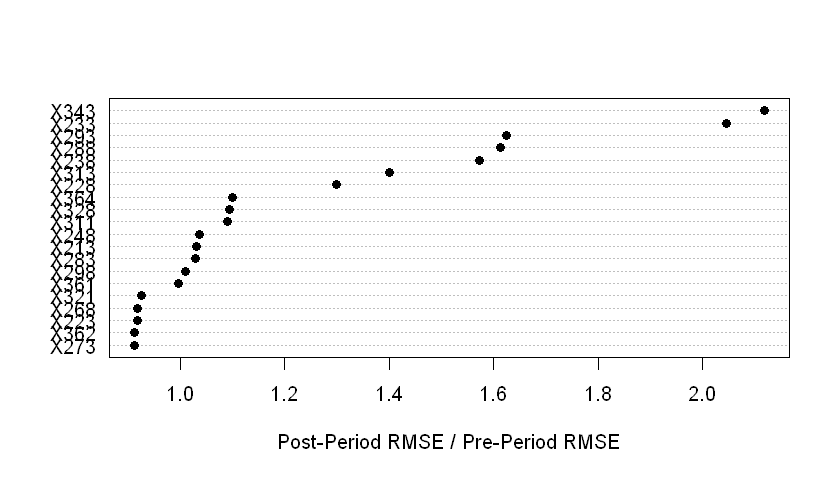

In [81]:
anios <- rownames(resultados)
t0 <- which(anios == year_t0)
t1 <- which(anios == year_t1)
t2 <- which(anios == year_t2)



preloss  <- apply(resultados[t0:t1,],2,rmse)
postloss <- apply(resultados[t0:t2,],2,rmse)

dotchart(sort(postloss/preloss),
         xlab="Post-Period RMSE / Pre-Period RMSE",
         pch=19)


In [ ]:
special_predictors  = list(list("REV_GDP", year_t0:year_t1, c("mean")),
                        #    list("WGI_CONTR_CORR", year_t0:year_t1, c("mean")),
                        #    list("WGI_GOV_EFFECT", year_t0:year_t1, c("mean")),
                        #    list("WGI_POL_STAB", year_t0:year_t1, c("mean")),
                           # list("WGI_REG_QUAL", year_t0:year_t1, c("mean")),
                           list("TRADE_OPEN", year_t0:year_t1, c("mean")),
                        #     list("CONSUMPTION_PC", year_t0:year_t1, c("mean")),
                            list("NET_FDI_GDP", year_t0:year_t1, c("mean")),
                           #  list("BROAD_MONEY_GDP", year_t0:year_t1, c("mean")),
                            list("LUR", year_t0:year_t1, c("mean")),
                            list("CAP_RETURN", year_t0:year_t1, c("mean")),
                           #  list("INT_RESERVES_CAP", year_t0:year_t1, c("mean")),
                            list("INFLATION", year_t0:year_t1, c("mean"))
                           #  list("POB", year_t0:year_t1, c("mean"))
                           #  list("POP", year_t0:year_t1, c("mean"))
                           #  list("COMDEP", year_t0:year_t1, c("mea